In [669]:
#%matplotlib inline
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
import scipy.stats as stt
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

In [1083]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

In [1084]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

In [1085]:
def load_data(selected_session,by_dir=False):
    
    """ Function to load data structured according to the format
        that the data were delivered to the retreat for
    """
    all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
    all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
    root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
    spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


    #This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
    spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

    #This is basically a big table (you can open it in excel) which contains
    #relevant information about each time the animal poked one of the ports
    task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

    #
    response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
    #alternatively to change the time window


    #not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
    single_units = np.load(os.path.join(root_dir,'single_units.npy'))
    
    
    seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
    seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))
    
    
    graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    graph_type1 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    
    if by_dir:
        firing_rate_maps = get_task_responses_by_direction(task_event_df,response_table)
    else:
        firing_rate_maps = get_task_responses(task_event_df,response_table)
    
    return firing_rate_maps, task_event_df,seq0,seq1,graph_type0,graph_type1

In [768]:
def get_task_responses_by_direction(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                                (task_event_df['correct']==True) &  #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction)
                                               ].index           
                #print(len(table_index))
                #get the average
                firing_rate_maps[:,int(port),int(task),dix] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

In [674]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            #for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
            table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                            (task_event_df['correct']==True) &  #the poke was to the correct port
                                            (task_event_df['port']==port)        #the port poked was port
                                            #(task_event_df['direction']==direction)
                                           ].index           
            #print(len(table_index))
            #get the average
            firing_rate_maps[:,int(port),int(task)] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps

In [769]:

firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(4)
#spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
mds_frm = firing_rate_maps.swapaxes(0,2) #- spatial_map[:,:,None,None]
#valid_ix = np.where(~np.isnan(np.sum(firing_rate_maps,axis=(0,2,3))))[0]
#frm = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])

In [ ]:
mds_

In [773]:
mds_frm.shape

(2, 9, 274)

In [771]:
graph_type1

'line'

In [678]:
#mean_state_resps = np.nanmean(mds_frm,axis=3).swapaxes(0,2)

In [679]:
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix

def zscore(dat): return (dat-np.mean(dat))/np.std(dat)

In [680]:
seq0_2 = np.array([list(seq0).index(i) for i in range(9)])
seq1_2 = np.array([list(seq1).index(i) for i in range(9)])

In [681]:
seq0

array([8, 1, 6, 3, 4, 0, 7, 2, 5])

In [682]:
#seq1

In [683]:
task_1_distance

array([[-0., -7., -1., -3., -2., -8., -4., -6., -5.],
       [-7., -0., -6., -4., -5., -1., -3., -1., -2.],
       [-1., -6., -0., -2., -1., -7., -3., -5., -4.],
       [-3., -4., -2., -0., -1., -5., -1., -3., -2.],
       [-2., -5., -1., -1., -0., -6., -2., -4., -3.],
       [-8., -1., -7., -5., -6., -0., -4., -2., -3.],
       [-4., -3., -3., -1., -2., -4., -0., -2., -1.],
       [-6., -1., -5., -3., -4., -2., -2., -0., -1.],
       [-5., -2., -4., -2., -3., -3., -1., -1., -0.]])

In [684]:
1-8

-7

In [685]:
9 +(8-2)

15

In [686]:
def loop_distance_matrix(seq,p=2):
    seq = list(seq)
    d = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
            ind1 = seq.index(i)
            ind2 = seq.index(j)
            d[i,j] = min([abs(ind1-ind2),abs(9+(ind1-ind2)),abs(9+(ind2-ind1))])**p
    return d

In [687]:
def line_distance_matrix(seq,p=1):
    seq = list(seq)
    d = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
            ind1 = seq.index(i)
            ind2 = seq.index(j)
            d[i,j] = abs(ind1-ind2)**p
    return d

In [688]:
#task_1_distance = loop_distance_matrix(seq0,p=2)
#task_2_distance = loop_distance_matrix(seq1,p=2)

In [689]:
if graph_type0=='loop': 
    task_1_distance = -loop_distance_matrix(seq0)
else: 
    task_1_distance =  -line_distance_matrix(seq0)#-(distance_matrix(seq0.reshape(-1,1),seq0.reshape(-1,1),p=1))
if graph_type1=='loop':
    task_2_distance = -loop_distance_matrix(seq1)
else:
    task_2_distance = -line_distance_matrix(seq1)#distance_matrix(seq1.reshape(-1,1),seq1.reshape(-1,1),p=1)
            
#task_1_distance = -(distance_matrix(seq0_2.reshape(-1,1),seq0_2.reshape(-1,1),p=1)%mod0)
#task_2_distance = -distance_matrix(seq1.reshape(-1,1)%mod1,seq1.reshape(-1,1)%mod1,p=2)
spatial_distance = -distance_matrix(poke_pos,poke_pos,p=1)

In [767]:
#for 

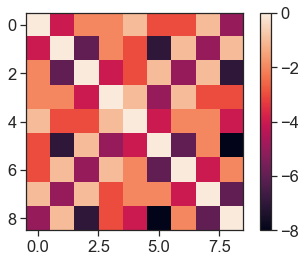

In [691]:
plt.imshow(task_1_distance)
plt.colorbar()

In [692]:
import statsmodels.api as sm

In [693]:
task1_corrs = np.corrcoef(mean_state_resps[0])
task2_corrs = np.corrcoef(mean_state_resps[1])

In [694]:
beta = np.linalg.inv(X.T@X)@X.T@y

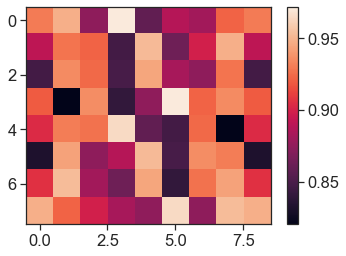

In [695]:
plt.imshow((X@beta).reshape(8,9))
plt.colorbar()

In [696]:
np.corrcoef(y,(X@beta))

array([[1.        , 0.77591699],
       [0.77591699, 1.        ]])

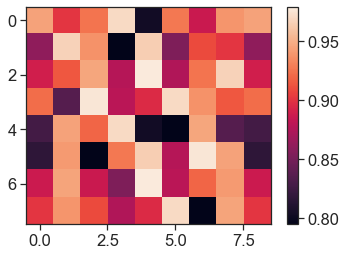

In [697]:
plt.imshow(y.reshape(8,9))
plt.colorbar()

In [698]:
def remove_diagonal(A):
    removed = A[~np.eye(A.shape[0], dtype=bool)].reshape(A.shape[0], int(A.shape[0])-1, -1)
    return np.squeeze(removed)


In [699]:
X = np.vstack([np.ones_like(remove_diagonal(spatial_distance).flatten()),
               zscore(remove_diagonal(spatial_distance).flatten()),
               zscore(remove_diagonal(task_1_distance).flatten()),
               zscore(remove_diagonal(task_2_distance).flatten())
              ]).T
y = remove_diagonal(task1_corrs).flatten()
res = sm.OLS(y,X,hasconst=True).fit()

In [700]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     60.65
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           3.42e-19
Time:                        11:28:18   Log-Likelihood:                 171.03
No. Observations:                  72   AIC:                            -334.1
Df Residuals:                      68   BIC:                            -325.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9126      0.003    334.535      0.000       0.907       0.918
x1             0.0255      0.003      8.158      0.000       0.019       0.032
x2             0.0166      0.003      5.271      0.000       0.010       0.023
x3            -0.0023      0.003     -0.820      0.415      -0.008       0.003
==============================================================================
Omnibus:                        1.675   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.433   Jarque-Bera (JB):                1.675
Skew:                          -0.304   Prob(JB):                        0.433
Kurtosis:                       2.567   Cond. No.                         1.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [701]:

y = remove_diagonal(task2_corrs).flatten()
res2 = sm.OLS(y,X,hasconst=True).fit()

In [702]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     59.26
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           6.04e-19
Time:                        11:28:19   Log-Likelihood:                 156.41
No. Observations:                  72   AIC:                            -304.8
Df Residuals:                      68   BIC:                            -295.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9039      0.003    270.440      0.000       0.897       0.911
x1             0.0295      0.004      7.705      0.000       0.022       0.037
x2             0.0214      0.004      5.540      0.000       0.014       0.029
x3            -0.0043      0.003     -1.267      0.209      -0.011       0.002
==============================================================================
Omnibus:                       13.845   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.033
Skew:                          -1.000   Prob(JB):                     0.000544
Kurtosis:                       4.003   Cond. No.                         1.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [703]:
res.params

array([ 0.91262661,  0.02551223,  0.01660387, -0.00225657])

In [1123]:
mean_state_resps

array([[[ 0.4986183 , -0.37898461, -0.69297978, ..., -0.70422438,
          2.70555097,  0.2795226 ],
        [ 1.99632558, -0.37898461, -0.30944159, ..., -0.24721702,
         -0.5883015 , -0.79261596],
        [-0.29611947, -0.37898461, -0.69297978, ...,  1.24844343,
         -0.11655911, -0.79261596],
        ...,
        [ 1.29047658, -0.37898461,  0.09077217, ..., -0.70422438,
         -0.81608384, -0.79261596],
        [-0.48486969,  0.61713929, -0.03747815, ...,  0.07684274,
         -0.47544571, -0.60742839],
        [-1.35365617, -0.37898461, -0.69297978, ...,  0.20979034,
          1.14853881, -0.14248939]],

       [[ 0.36349151,  1.38833198,  1.63299375, ..., -0.70422438,
          0.99699008,  1.83585276],
        [-0.08939304, -0.37898461, -0.69297978, ...,  0.52316682,
         -0.39550003, -0.50160692],
        [-1.23987058, -0.37898461,  2.58452837, ..., -0.70422438,
         -0.53221873,  2.29384352],
        ...,
        [-0.36952234, -0.37898461,  1.7105262 , ..., -

(0, 1)

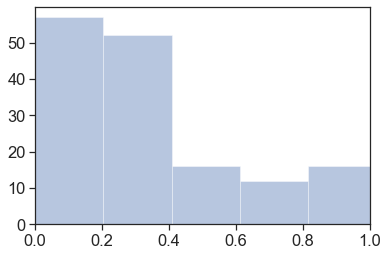

In [1142]:
seaborn.distplot(firing_rate_maps.max(axis=(1,2)),kde=0,bins=np.linspace(0,10,num=50))
plt.xlim(0,1)

In [1190]:
np.std(mean_state_resps,axis=(0,1))[None,None,:]

array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [1191]:
all_beta = []
all_pvals = []
for sess_ix in range(8):
    tmp  = []
    tmp_pvals = []
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix)
    mxs = firing_rate_maps.max(axis=(1,2))
    firing_rate_maps = firing_rate_maps[mxs>1]
    mean_state_resps = firing_rate_maps.swapaxes(0,2)
    mean_state_resps = (mean_state_resps - np.mean(mean_state_resps,axis=(0,1))[None,None,:])/np.std(mean_state_resps,axis=(0,1))[None,None,:]
    mean_state_resps = np.nan_to_num(mean_state_resps)
    #mean_state_resps = np.nanmean(mds_frm,axis=3).swapaxes(0,2)
    if graph_type0=='loop': 
        task_1_distance = -loop_distance_matrix(seq0)
    else: 
        task_1_distance =  -line_distance_matrix(seq0)
    if graph_type1=='loop':
        task_2_distance = -loop_distance_matrix(seq1)
    else:
        task_2_distance = -line_distance_matrix(seq1)

    spatial_distance = -distance_matrix(poke_pos,poke_pos,p=1)
    
    task1_corrs = np.corrcoef(mean_state_resps[0])
    task2_corrs = np.corrcoef(mean_state_resps[1])
    
    
    #
    X = np.vstack([np.ones_like(remove_diagonal(spatial_distance).flatten()),
               zscore(remove_diagonal(spatial_distance).flatten()),
               zscore(remove_diagonal(task_1_distance).flatten()),
               zscore(remove_diagonal(task_2_distance).flatten())
              ]).T
    y = remove_diagonal(task1_corrs).flatten()
    beta = np.linalg.inv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    
    tmp.append(beta.copy())
    tmp_pvals.append(res.pvalues)
    
    y = remove_diagonal(task2_corrs).flatten()
    beta = np.linalg.inv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    tmp_pvals.append(res.pvalues)
    tmp.append(beta.copy())
    
    all_beta.append(tmp)
    all_pvals.append(tmp_pvals)
    #assert np.allclose(beta,res.params)

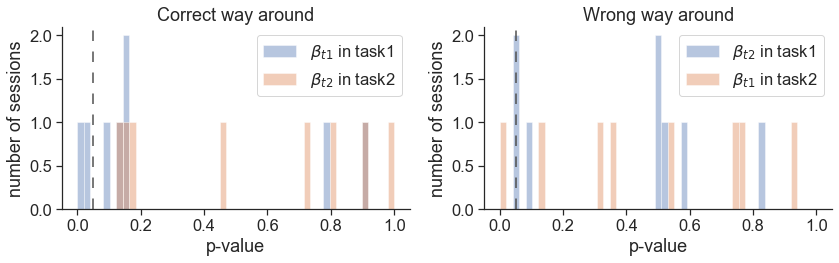

In [1192]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Correct way around")
seaborn.distplot(np.array(all_pvals)[:,0,-2],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t1}$ in task1')
seaborn.distplot(np.array(all_pvals)[:,1,-1],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t2}$ in task2')
plt.axvline(x=0.05,dashes=(7,7),color='.3')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()

plt.subplot(1,2,2)
plt.title("Wrong way around")
seaborn.distplot(np.array(all_pvals)[:,0,-1],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t2}$ in task1')
seaborn.distplot(np.array(all_pvals)[:,1,-2],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t1}$ in task2')
plt.axvline(x=0.05,dashes=(7,7),color='.3')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()
plt.tight_layout()

In [1193]:
np.array(all_pvals)[:,:,-2:].shape

(8, 2, 2)

In [1194]:
res.pvalues

array([1.83085565e-03, 3.46281380e-12, 9.18367580e-01, 1.42188461e-01])

In [1195]:
#n_sessions x n_tasks x n_params
all_beta = np.array(all_beta)

In [1196]:
t1_m_t2_inT1 = (all_beta[:,0,-2] - all_beta[:,0,-1])
t1_m_t2_inT2 = (all_beta[:,1,-1] - all_beta[:,1,-2])

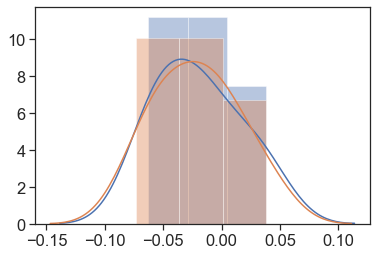

In [1197]:
seaborn.distplot(t1_m_t2_inT1)
seaborn.distplot(t1_m_t2_inT2)

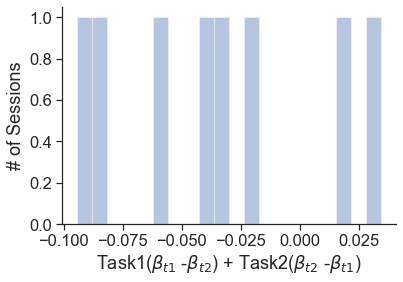

In [1188]:
seaborn.distplot(t1_m_t2_inT1 + t1_m_t2_inT2,kde=0,bins=20)
plt.xlabel(r"Task1($\beta_{t1}$ -$\beta_{t2}$) + Task2($\beta_{t2}$ -$\beta_{t1}$)")
plt.ylabel("# of Sessions")
seaborn.despine()

In [1189]:
stt.ttest_1samp(t1_m_t2_inT1 + t1_m_t2_inT2,popmean=0)

Ttest_1sampResult(statistic=-2.1463922101627073, pvalue=0.06898012880281545)

# RSA Task distance with direction

In [1086]:

firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(0,by_dir=True)
#spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
mds_frm = firing_rate_maps #- spatial_map[:,:,None,None]
#valid_ix = np.where(~np.isnan(np.sum(firing_rate_maps,axis=(0,2,3))))[0]
#firing_rate_maps[:,int(port),int(task),dix]
frm = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])

In [1087]:
frm_t1 = frm[:,:18]
frm_t2 = frm[:,18:]

In [1088]:
#this constructs the appropriate things if everything is ordered correctly according to states

T = np.zeros([18,18])
for i in range(9):
    T[i,(i+1)%9] = .95
    T[i,9+(i-1)%9] =0.05
    
for i in range(9,18):
    T[i,(i+1)%9] = .05
    T[i,9+(i-1)%9] =0.95

In [1089]:
def get_C_tasks(seq0,seq1):
    #this constructs the appropriate things if everything is ordered correctly according to states

    T1 = np.zeros([18,18])
    for i in range(9):
        T1[seq0[i],seq0[(i+1)%9]] = .95
        T1[seq0[i],9+seq0[(i-1)%9]] =0.05

    for i in range(9,18):
        T1[seq0[i%9]+9,seq0[(i+1)%9]] = .05
        T1[seq0[i%9]+9,9+seq0[(i-1)%9]] =0.95
        
    return 

In [1090]:
#this constructs the appropriate things if everything is ordered correctly according to states

T1 = np.zeros([18,18])
for i in range(9):
    T1[seq0[i],seq0[(i+1)%9]] = .95
    T1[seq0[i],9+seq0[(i-1)%9]] =0.05
    
for i in range(9,18):
    T1[seq0[i%9]+9,seq0[(i+1)%9]] = .05
    T1[seq0[i%9]+9,9+seq0[(i-1)%9]] =0.95

In [1091]:
#this constructs the appropriate things if everything is ordered correctly according to states

T2 = np.zeros([18,18])
for i in range(9):
    T2[seq1[i],seq1[(i+1)%9]] = .95
    T2[seq1[i],9+seq1[(i-1)%9]] =0.05
    
for i in range(9,18):
    T2[seq1[i%9]+9,seq1[(i+1)%9]] = .05
    T2[seq1[i%9]+9,9+seq1[(i-1)%9]] =0.95

In [1092]:
task_1_distance = -np.log(expm(T1))
task_2_distance = -np.log(expm(T2))

In [1093]:
evals, evecs = np.linalg.eig(T)
evals_mtx = np.eye(len(evals))*evals
evec1 = evecs[:,np.isclose(evals, 1)]

#Since np.isclose will return an array, we've indexed with an array
#so we still have our 2nd axis.  Get rid of it, since it's only size 1.
evec1 = evec1[:,0]

stationary = evec1 / evec1.sum()

#eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
stationary = stationary.real


In [1094]:
#plt.imshow((evecs@(evals_mtx**2000)@np.linalg.inv(evecs)).real,interpolation="None")
#plt.colorbar()

In [1095]:
#plt.imshow(T@T@T@T@T@T@T@T@T,vmin=0,vmax=1)
#plt.colorbar()

In [1096]:
from scipy.linalg import expm

In [1097]:
evals, evecs = np.linalg.eig(T)
C1 = -np.log(expm(T))

In [1098]:
C2 = -np.log(evecs@expm(evals_mtx)@np.linalg.inv(evecs))

In [1099]:
spatial_distance =  spatial_distance = -distance_matrix(np.vstack([poke_pos,poke_pos]),
                                                        np.vstack([poke_pos,poke_pos]),p=1)

In [1100]:
task1_corrs = np.corrcoef(frm_t1.T)
task2_corrs = np.corrcoef(frm_t2.T) 

select_indices = (np.eye(len(task1_corrs)) + np.isnan(task1_corrs) + np.isnan(task2_corrs))==0

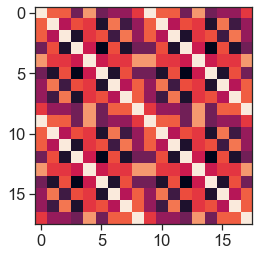

In [1101]:
plt.imshow(spatial_distance)

In [1106]:
spatial_distance[select_indices]

(306,)

In [1107]:
17**2

289

In [1102]:
y = zscore(task2_corrs[select_indices].flatten())
X = np.vstack([np.ones_like(y),
           zscore(spatial_distance[select_indices].flatten()),
           zscore(task_1_distance[select_indices].flatten()),
           zscore(task_2_distance[select_indices].flatten())
          ]).T
beta = np.linalg.inv(X.T@X)@X.T@y
res = sm.OLS(y,X,hasconst=True).fit()


In [1103]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     9.996
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           2.67e-06
Time:                        15:24:58   Log-Likelihood:                -419.71
No. Observations:                 306   AIC:                             847.4
Df Residuals:                     302   BIC:                             862.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.182e-15      0.055   7.62e-14      1.000      -0.108       0.108
x1             0.2974      0.056      5.347      0.000       0.188       0.407
x2            -0.0246      0.055     -0.444      0.657      -0.134       0.085
x3             0.0187      0.055      0.339      0.735      -0.090       0.127
==============================================================================
Omnibus:                        8.162   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.332
Skew:                          -0.381   Prob(JB):                       0.0155
Kurtosis:                       2.730   Cond. No.                         1.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

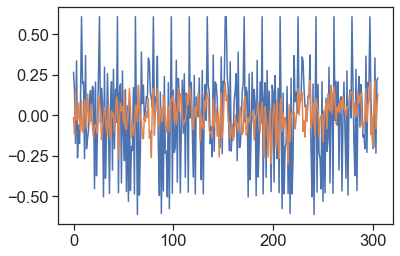

In [1104]:
plt.plot(X@beta)
plt.plot(y/10)
